<a href="https://colab.research.google.com/github/PMH2906/Deeplearning-system/blob/main/ResNet_FashionMNIST_Adam%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Hyper-parameters
num_epochs = 20
batch_size = 100
learning_rate = 0.001

In [4]:
# Image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

In [5]:
# CIFAR-10 dataset
train_dataset = torchvision.datasets.FashionMNIST(root='../../data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.FashionMNIST(root='../../data/',
                                            train=False, 
                                            transform=transforms.ToTensor())


Extracting ../../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../../data/FashionMNIST/raw




Extracting ../../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../../data/FashionMNIST/raw




Extracting ../../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/FashionMNIST/raw




Extracting ../../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/FashionMNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [7]:
# ResNet18을 위해 최대한 간단히 수정한 BasicBlock 클래스 정의
class BasicBlock(nn.Module): # 논문에서 그림으로 나오는 layers에서 하나의 Block
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        # 3x3 필터를 사용 (너비와 높이를 줄일 때는 stride 값 조절 -> dimension을 줄임)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        # 3x3 필터를 사용 (패딩을 1만큼 주기 때문에 너비와 높이가 동일)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        self.shortcut = nn.Sequential() # identity인 경우
        if stride != 1: # stride가 1이 아니라면, Identity mapping이 아닌 경우
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False), # 동일한 차원으로 변경을 함
                nn.BatchNorm2d(planes)
            )

    def forward(self, x): # forward 함수는 호출하지 않아도 model 객체를 데이터와 함께 호출하면 자동으로 실행됨
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # (핵심) skip connection
        out = F.relu(out)
        return out


# ResNet 클래스 정의
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10): # 본 모델은 capacity가 커서 num_classess를 1000으로 바꾸고 ImageNet을 학습시켜도 됨
        super(ResNet, self).__init__()
        self.in_planes = 64

        # 64개의 3x3 필터(filter)를 사용
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False) # 처음 input layer에 들어가는 채널의 크기가 1이다. MINST는 gray scale이기 때문
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1) # num_blocks=2개 만큼 BasicBlock을 실행하고 BasicBlock에서는 2개의 layers가 있으므로 layer1에서는 총 4개의 conv layer을 지남
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2) # layer2도 4개
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2) # 3도 4개
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2) # 4도 4개
        self.linear = nn.Linear(512, num_classes) # 총 16개 layers이고 마지막에 fully connected layer을 가지고 있음

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1) # 위에 layers를 만들때 처음 layer에만 stride 값이 2가 되게끔 함. 논문 그림을 보면 너비와 높이가 처음 BasicBlock을 들어갈때 반으로 줄어듦
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes # 다음 레이어를 위해 채널 수 변경
        return nn.Sequential(*layers)

    def forward(self, x): # forward 함수는 호출하지 않아도 model 객체를 데이터와 함께 호출하면 자동으로 실행됨
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out # 최종적으로 10개의 클래스가 나옴


# ResNet18 함수 정의
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2]) # 각각 2번씩 BasicBlock을 사용함

In [8]:
model = ResNet18().to(device)

In [9]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [10]:
# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


In [12]:
total_step = len(train_loader)
Loss = []
Acc = []
Val_Loss = []
Val_Acc = []

for epoch in range(num_epochs):
  acc = 0
  val_acc = 0
  for i, (images, labels) in enumerate(train_loader):
    model.train()
    images = images.to(device)
    labels = labels.to(device)
    
    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Checking accuracy
    preds = outputs.data.max(dim=1,keepdim=True)[1]
    acc += preds.eq(labels.data.view_as(preds)).cpu().sum()
    
  acc = acc/len(train_loader.dataset) * 100
    
  for i, (images, labels) in enumerate(test_loader):
    model.eval()
    images = images.to(device)
    labels = labels.to(device)
    
    # Forward pass
    outputs = model(images)
    val_loss = criterion(outputs, labels)
    
    # Checking accuracy
    preds = outputs.data.max(dim=1,keepdim=True)[1]
    val_acc += preds.eq(labels.data.view_as(preds)).cpu().sum()
    
  val_acc = val_acc/len(test_loader.dataset) * 100
    
  print("Epoch {} =>  loss : {loss:.2f};   Accuracy : {acc:.2f}%;   Val_loss : {val_loss:.2f};   Val_Accuracy : {val_acc:.2f}%".format(epoch+1, loss=loss.item(), acc=acc, val_loss=val_loss.item(), val_acc=val_acc))
  
  Loss.append(loss)
  Acc.append(acc)

  Val_Loss.append(val_loss)
  Val_Acc.append(val_acc)


Epoch 1 =>  loss : 0.31;   Accuracy : 86.43%;   Val_loss : 0.45;   Val_Accuracy : 83.10%
Epoch 2 =>  loss : 0.21;   Accuracy : 89.60%;   Val_loss : 0.36;   Val_Accuracy : 87.35%
Epoch 3 =>  loss : 0.17;   Accuracy : 91.00%;   Val_loss : 0.38;   Val_Accuracy : 89.75%
Epoch 4 =>  loss : 0.34;   Accuracy : 91.84%;   Val_loss : 0.33;   Val_Accuracy : 90.71%
Epoch 5 =>  loss : 0.13;   Accuracy : 92.31%;   Val_loss : 0.31;   Val_Accuracy : 90.29%
Epoch 6 =>  loss : 0.25;   Accuracy : 92.66%;   Val_loss : 0.47;   Val_Accuracy : 89.82%
Epoch 7 =>  loss : 0.11;   Accuracy : 92.96%;   Val_loss : 0.37;   Val_Accuracy : 91.88%
Epoch 8 =>  loss : 0.15;   Accuracy : 93.34%;   Val_loss : 0.36;   Val_Accuracy : 90.44%
Epoch 9 =>  loss : 0.20;   Accuracy : 93.63%;   Val_loss : 0.37;   Val_Accuracy : 92.43%
Epoch 10 =>  loss : 0.22;   Accuracy : 93.90%;   Val_loss : 0.25;   Val_Accuracy : 92.39%
Epoch 11 =>  loss : 0.08;   Accuracy : 94.09%;   Val_loss : 0.24;   Val_Accuracy : 92.73%
Epoch 12 =>  loss :

In [13]:
import matplotlib.pyplot as plt

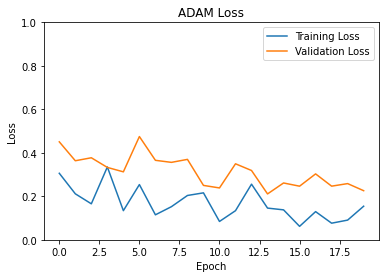

In [14]:
plt.plot(range(num_epochs),Loss)
plt.plot(range(num_epochs),Val_Loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim([0,1.0])
plt.title("ADAM Loss")
plt.legend(["Training Loss", "Validation Loss"])
plt.show()

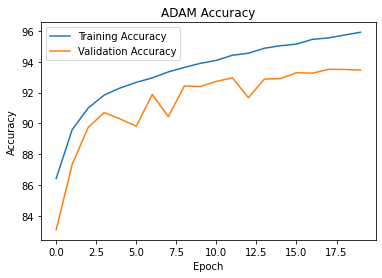

In [15]:
plt.plot(range(num_epochs),Acc)
plt.plot(range(num_epochs),Val_Acc)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title("ADAM Accuracy")
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.show()